In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup

import tweepy as tw
import json
from wordcloud import WordCloud
from PIL import Image
import unicodedata
import emoji
import nltk
nltk.download('words')
words = set(nltk.corpus.words.words())

with open('twitter_auth.json') as f:
    auth = json.load(f)
    consumer_key = auth['consumer_key']
    consumer_secret = auth['consumer_key_secret']
    access_token = auth['access_key']
    access_token_secret = auth['access_key_secret']

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\hotal\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
# Logging into Twitter through the tweepy package

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tw.API(auth)

In [3]:
# Define the search term and the date_since date as variables
search_words = input("Select a Search Topic: ")
date_since = "2000-11-16"

# Add some other conditions like removing retweets and searching for verified only accounts
new_search = search_words + " -filter:retweets" #+ " filter:verified"

Select a Search Topic: adfasfvnagjsvnsa


In [4]:
# Retrieving the results from our search

tweets = tw.Cursor(api.search,
                       q=new_search,
                       lang="en",
                       since=date_since).items(1000)

# Add the results to a dataframe
data = [[tweet.user.screen_name, tweet.text,tweet.favorite_count, tweet.retweet_count] for tweet in tweets]
tweet_text = pd.DataFrame(data=data, 
                    columns=['user','text','likes','retweets'])
tweet_text

,user,text,likes,retweets


In [5]:
def cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = ''.join(c for c in tweet if c not in emoji.UNICODE_EMOJI) #Remove Emojis
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) \
         if w.lower() in words or not w.isalpha())
    return tweet
tweet_text['tweet'] = tweet_text['text'].map(lambda x: cleaner(x))
#tweet_text.to_csv('') #specify location

In [6]:
plane_mask = np.array(Image.open('test.jpg'))

In [7]:
string = ""
for i in tweet_text['tweet'].values:
    i = i.split()
    for j in i:
        if len(j) > 2 and j.lower() != "spotted":
            string += j.lower() +" "

In [8]:
wordcloud = WordCloud(background_color ='#f6faf0', colormap = 'gist_heat', width=1000, height=1000, mask=plane_mask).generate(string)

ValueError: We need at least 1 word to plot a word cloud, got 0.

In [ ]:
plt.figure(figsize=(16,16))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Words Associated with Air Travel', loc='Left', fontsize=14)
plt.imshow(np.array(Image.open('test.jpg').convert('L')), alpha = 0.05, )
plt.gray()
plt.savefig('aircraft_wordcloud.png', dpi=500)

plt.show()

In [9]:
df = pd.read_csv("Airplane_Crashes_and_Fatalities_Since_1908.csv")
df.head()
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = pd.to_datetime(df['Date']).apply(lambda x: '{year}'.format(year=x.year))
df['Year'] = df['Year'].apply(int)
df.head()

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary,Year
0,1908-09-17,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly...",1908
1,1912-07-12,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...,1912
2,1913-08-06,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...,1913
3,1913-09-09,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encou...,1913
4,1913-10-17,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...,1913


In [10]:
# Need to remove duplicate ground fatalties from second 9/11 twin towers plane
df.at[4804, 'Ground'] = '0'
#df[df['Date'] == "2001-09-11"]

In [11]:
results = df.groupby('Year').sum()
results = results[['Fatalities','Ground']]
results.columns = ["Total Fatalities per Year","Ground Based Fatalities"]

Text(0.5, 1.0, 'Fatalities from Airline Travel per Year')

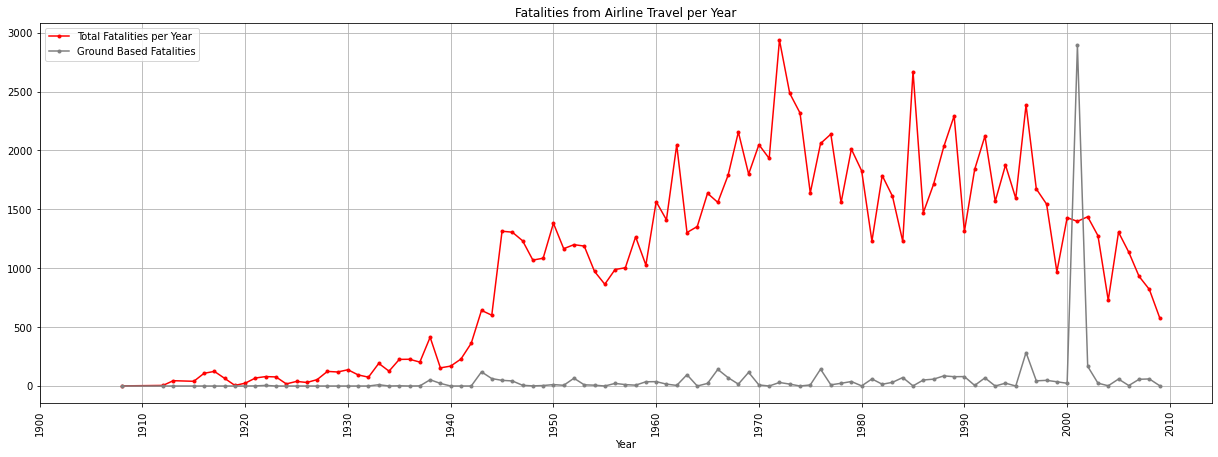

In [12]:
results.plot(figsize=(21,7), grid = True, color = ['red','gray'], style = ".-")
plt.xticks(rotation = 90, ticks = np.arange(1900,2020,10))
plt.title("Fatalities from Airline Travel per Year")

In [13]:
def basic_clean(text):
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ['amp','rt'] 
    text = (unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore').lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [14]:
df = df[~df['Operator'].str.contains("Military",na=False)]

In [15]:
df = df[df['Aboard'] > 10]
df = df[df['Year'].apply(int) > 1985]
df

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary,Year
2514,1991-02-22,NaN,"Cazombo, Angola",Fuerza Area Angolaise,NaN,NaN,Antonov AN-26,NaN,NaN,47.0,47.0,0.0,Shot down by surface-to-air missile launced by...,1991
3599,1986-01-18,08:00,"Near Peten, Guatemala",Aerovias de Guatemala SA,NaN,Guatemala City - Flores,Sud-Aviation Caravelle VI-N,HC-BAE,040,87.0,87.0,0.0,After initiating an overshoot and attempting t...,1986
3601,1986-01-28,07:45,"Sao Paulo, Brazil",VASP,NaN,Sao Paulo - Belo Horizonte,Boeing B-737-2A1,PP-SME,20096/190,72.0,1.0,0.0,The crew accidently tried to take off from a t...,1986
3602,1986-01-29,NaN,"Las Lomitas, Mexico",Aerocalifornia,NaN,Villa Constitucion - Los Mochis,Douglas DC-3A-178,XA-IOR,1547,21.0,21.0,0.0,The plane tried to land at Los Mochis but had ...,1986
3603,1986-02-05,NaN,"Kasongo, Zaire",GLM Aviation,NaN,NaN,Lockheed L-188AF Electra,9Q-CWT,1045,14.0,2.0,0.0,Crashed while attempting to make a forced land...,1986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5254,2009-03-22,14:28,"Butte, Montana",Eagle Cap Leasing,NaN,"Oroville, CA - Butte, MT",Pilatus PC-12/45,N128CM,403,14.0,14.0,0.0,The plane crashed 500 feet short of the runway...,2009
5256,2009-04-01,14:00,"Off Crimond, Scotland",Bond Offshore Helicopters,NaN,Miller field - Aberdeen,Eurocopter AS 332L2 Super Puma 2,NaN,NaN,16.0,16.0,0.0,The helicopter crashed 35 miles East of Crimon...,2009
5259,2009-04-17,10:30,"Mount Gergaji, Indonesia",Mimika Air,514,Ilaga - Mulia,Pilatus PC-6,PK-LTJ,959,11.0,11.0,0.0,The passenger plane crashed in poor weather in...,2009
5260,2009-04-17,15:32,"Canaima National Park, Venezuela",Aerotuy airline,NaN,Canaima - Porlamar,Cessna 208B Grand Caravan,YV-1181,208B-0695,11.0,1.0,0.0,"The plane, carrying 9 tourists, crashed 5 mile...",2009


In [16]:
words = basic_clean(''.join(str(df['Summary'].tolist())))

In [17]:
incident_summary = df[~df['Summary'].isna()]

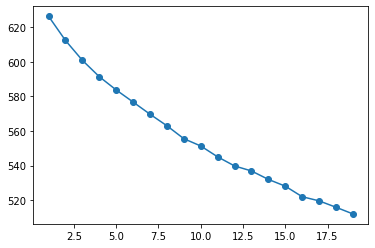

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

vectorizer = TfidfVectorizer(stop_words=nltk.corpus.stopwords.words('english'), max_features=200)
X = vectorizer.fit_transform(incident_summary['Summary'])
feats = vectorizer.get_feature_names()

error = []
for i in range(1,20):
    kmeans = KMeans(n_clusters=i).fit(X)
    error.append(kmeans.inertia_)
plt.plot(range(1,20), error)
plt.scatter(range(1,20), error)


Text(0, 0.5, '')

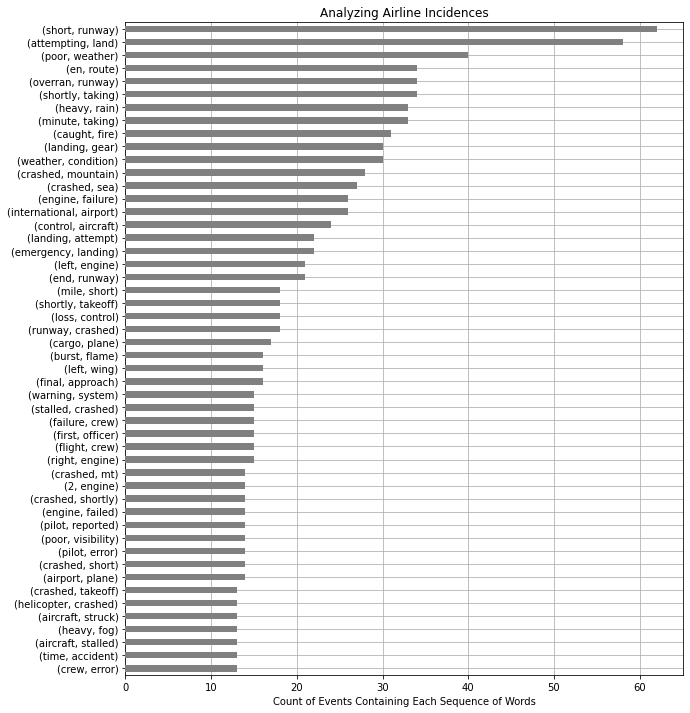

In [19]:
trigrams = (pd.Series(nltk.ngrams(words, 2)).value_counts())
trigrams[2:52].sort_values(ascending=True).plot(kind='barh', figsize = (10,12), color = "gray", zorder=5)
plt.title("Analyzing Airline Incidences")
plt.xlabel("Count of Events Containing Each Sequence of Words")
plt.grid(True)
plt.ylabel("")

In [20]:
aboard = []
fatalites = []
ground = []
counts = []

for ng1,ng2 in trigrams.index[:50]:
    tmp = incident_summary[(incident_summary['Summary'].str.contains(ng1)) & (incident_summary['Summary'].str.contains(ng2))]
    x,y,z = tmp[['Aboard','Fatalities','Ground']].sum()
    counts.append(len(tmp))
    aboard.append(x)
    fatalites.append(y)
    ground.append(z)
    
ngram_grouping = pd.DataFrame([trigrams.index[:50], counts,aboard,fatalites,ground]).T
ngram_grouping.columns = ['ngrams','counts','aboard','fatalities','ground']
ngram_grouping = ngram_grouping[ngram_grouping['aboard'] > 0]
ngram_grouping['fatal_rate'] = ngram_grouping['fatalities'] / ngram_grouping['aboard']
ngram_grouping = ngram_grouping.sort_values('counts', ascending=True)[2:]
ngram_grouping.to_csv("ngrams.csv")
ngram_grouping

,ngrams,counts,aboard,fatalities,ground,fatal_rate
36,"(poor, visibility)",13,687,492,4,0.716157
33,"(first, officer)",13,1820,1343,5,0.737912
22,"(shortly, takeoff)",16,999,955,123,0.955956
40,"(pilot, error)",16,1571,1157,5,0.736474
35,"(right, engine)",16,670,332,12,0.495522
45,"(time, accident)",17,1407,848,2,0.602701
42,"(pilot, reported)",18,1765,1338,4,0.758074
49,"(helicopter, crashed)",18,294,236,0,0.802721
43,"(engine, failed)",20,1149,883,5,0.768494
26,"(cargo, plane)",21,1093,557,87,0.509607


In [ ]:
ngram_grouping.index = ngram_grouping['ngrams']
ngram_grouping['counts'].plot(kind='barh', figsize = (10,12), color='cornflowerblue')
plt.title("Analyzing Airline Incidences")
plt.xlabel("Count of Events Containing Each Sequence of Words")
plt.ylabel("")

In [ ]:
df['weather'] = df['Summary'].str.contains('rain',na=False)|df['Summary'].str.contains('snow',na=False)|df['Summary'].str.contains('sleet',na=False)|df['Summary'].str.contains('weather',na=False)|df['Summary'].str.contains('fog',na=False)|df['Summary'].str.contains('lightning',na=False)|df['Summary'].str.contains('icing',na=False)|df['Summary'].str.contains('ice',na=False)|df['Summary'].str.contains('sleet',na=False)|df['Summary'].str.contains('weather',na=False)|df['Summary'].str.contains('fog',na=False)|df['Summary'].str.contains('lightning',na=False)|df['Summary'].str.contains('icing',na=False)|df['Summary'].str.contains('thunderstorm',na=False)
df['hijack'] = df['Summary'].str.contains('hijack',na=False)
df['shot down'] = df['Summary'].str.contains('shot down',na=False)|df['Summary'].str.contains('missile',na=False)
df['engine'] = df['Summary'].str.contains('engine',na=False)|df['Summary'].str.contains('stalled',na=False)
df['landing gear'] = df['Summary'].str.contains('landing gear',na=False)
df['collision'] = df['Summary'].str.contains('hit',na=False)
df['terrorism'] = df['Summary'].str.contains('bomb', na=False)|df['Summary'].str.contains('knife', na=False)
df['during touchdown'] = df['Summary'].str.contains("approach",na=False)|df['Summary'].str.contains("landing",na=False)
df['during takeoff'] = df['Summary'].str.contains("takeoff", na=False)|df['Summary'].str.contains("taking off", na=False)|df['Summary'].str.contains("taking-off", na=False)

In [ ]:
for i in df[df['weather'] != True]['Summary'].sample(2):
    print(i)
    print("")

In [ ]:
cars = pd.read_csv("DP_LIVE_22042021195815124.csv")
cars.groupby('TIME').sum()[0:-2].plot()
plt.ylim(0,20000000)

In [ ]:
car_fatalities = cars.groupby('TIME').sum()
car_fatalities['Year'] = car_fatalities.index

In [ ]:
df = pd.read_csv("Airplane_Crashes_and_Fatalities_Since_1908.csv")
df.head()
df['Date'] = pd.to_datetime(df['Date'])
df = df[~df['Operator'].str.contains("Military",na=False)]
df['Year'] = pd.to_datetime(df['Date']).apply(lambda x: '{year}'.format(year=x.year))

In [ ]:
df['Year'] = df['Year'].apply(int)
plane_fatalties = df[df['Year']>= 1970].groupby('Year').sum()

In [ ]:
cars_and_planes = pd.concat([car_fatalities, plane_fatalties], axis = 1, join='outer')
cars_and_planes = cars_and_planes.head(40)
cars_and_planes = cars_and_planes[['Value','Fatalities']]
#cars_and_planes['percentage'] = cars_and_planes['Value'] / cars_and_planes['Fatalities']
cars_and_planes.head()

In [ ]:
cars_and_planes.columns = ['Automobile Fatalties','Air Travel Fatalities']
cars_and_planes.plot(figsize=(10,12),logy=True, grid = True,color = ['black','red','white'])
plt.title("Comparing Road Fatalties to Air Travel Fatalties")
plt.ylabel("Number of Fatalties per Year (Log Scale)")

In [ ]:
#cars_and_planes['percentage'] = cars_and_planes['Automobile Fatalties'] / cars_and_planes['Air Travel Fatalities']
cars_and_planes.tail(1).T

In [ ]:
tmp = cars_and_planes.sum().T.plot(kind='pie', colors = ['gray','white'], figsize = (6,6), explode = [0,0], autopct='%1.3f%%')
plt.ylabel("")
plt.title("Fatalities from Automobiles Compared with Air Travel")

In [ ]:
flights = pd.read_csv("API_IS.AIR.PSGR_DS2_en_csv_v2_2252261.csv", skiprows = 3)
flights.drop(['Unnamed: 65'], axis = 1, inplace = True)
flights = flights.melt(['Country Name','Country Code','Indicator Name','Indicator Code'], var_name="Year", value_name='Count')
flights = flights.groupby('Year').sum()
flights = flights[flights['Count'] > 0]
flights['Count'] = flights['Count'] / 10000000000
flights['Year'] = flights.index
flights['Year'] = flights['Year'].apply(int)

In [ ]:
#flights.plot(kind = 'bar', figsize=(19,5), color = 'gray')
#flights[-1:].plot(kind = 'bar', figsize=(19,5), color = 'red')

plt.figure(figsize=(19,7))
plt.bar(x=flights['Year'], height = flights['Count'], color = 'gray')
plt.bar(x=flights['Year'][-1:], height = flights['Count'][-1], color = 'red')
plt.xticks(rotation = 90, ticks = np.arange(1970,2020,1))
plt.xlim(1969,2020)

plt.title("Number of Airline Passengers")
plt.ylabel("Number of Airline Passengers (Billions)")

In [ ]:
flights[-1:]